In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

import pyAgrum.skbn as skbn

import causalml.inference.meta.slearner as slearner
import causalml.inference.meta.tlearner as tlearner
import causalml.inference.meta.xlearner as xlearner
import causalml.inference.meta.rlearner as rlearner

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [11]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from estimation_class.ATEestimation import PotentialOutcomes

In [12]:
# Model parameters
XI = np.array([-1, 1, 1])
NU = np.array([0, -1, 1, -1, 2])
BETA = np.array([0, 0.6, -0.6, 0.6])
TAU_0 = np.array([-1, -1, 1, 1])
TAU_1 = TAU_0 * -1
SIGMA = np.array([[1, 0.5, -0.5, -0.5],
                  [0.5, 1, -0.5, -0.5],
                  [-0.5, -0.5, 1, 0.5],
                  [-0.5, -0.5, 0.5, 1]], dtype=float)

#SIGMA = np.ones((4,4)) * 0.001

def generate_lunceford(n=1000):
    # Generate data
    x3 = np.random.binomial(1, 0.2, n)
    v3 = np.random.binomial(1, (0.75 * x3 + (0.25 * (1 - x3))), n)

    # If x3=0 you have a model, if x3=1 you have another one
    x1v1x2v2_x3_0_matrix = np.random.multivariate_normal(TAU_0, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3_1_matrix = np.random.multivariate_normal(TAU_1, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3 = np.where(np.repeat(x3[:, np.newaxis], 4, axis=1) == 0, x1v1x2v2_x3_0_matrix, x1v1x2v2_x3_1_matrix)

    # Concatenate values
    xv = np.concatenate([x1v1x2v2_x3, np.expand_dims(x3, axis=1), np.expand_dims(v3, axis=1)], axis=1)

    # Compute e, a, and y
    x = xv[:, [0,2,4]]
    v = xv[:, [1,3,5]]
    e = np.power(1 + np.exp(- BETA[0] - x.dot(BETA[1:])), -1)
    a = np.random.binomial(1, e, n)
    y = x.dot(NU[1:-1]) + v.dot(XI) + a*NU[-1] + np.random.binomial(1, e, n) + np.random.normal(0, 1, n)

    # Create the final df
    synthetic_data_df = pd.DataFrame(np.concatenate([x, np.expand_dims(a, axis=1), v, np.expand_dims(y, axis=1)], axis=1), columns=["X1", "X2", "X3", "T", "V1", "V2", "V3", "Y"])
    synthetic_data_df["X3"] = synthetic_data_df["X3"].astype(int)
    synthetic_data_df["V3"] = synthetic_data_df["V3"].astype(int)
    synthetic_data_df["T"] = synthetic_data_df["T"].astype(int)

    return synthetic_data_df

In [13]:
df = generate_lunceford(int(1e6))
df.head()

,X1,X2,X3,T,V1,V2,V3,Y
0,-0.758087,0.367691,0,1,0.486810,1.327539,0,6.784085
1,1.389120,-0.051103,1,1,0.096084,-0.811698,1,1.259889
2,0.889776,-0.621311,0,1,0.124574,-0.229889,0,-1.266944
3,-1.698963,1.198091,0,0,-1.250949,0.886625,1,5.318481
4,-0.655888,0.672255,0,0,-1.202871,0.766782,0,3.944279


In [14]:
from scipy.stats import norm, logistic

def getBN(# Covariate parameters
          covariate_start : int = -5.0,
          covariate_end : int = 5.0 ,
          covariate_num_split : int = 10,
          # Outcome parameters
          outcome_start = -10.0 ,
          outcome_end = 15.0 ,
          outcome_num_split = 60,
          # Other
          data : pd.DataFrame | None = None,
          add_arcs : bool = True,
          fill_distribution : bool = True) -> gum.BayesNet:
    """
    Returns Baysian Network corresponding to the model by discretising
    countinous variables with given parameters.
    """
    if data is None:
        plus = "" if fill_distribution else "+"
        bn = gum.BayesNet()
        for i in range(1,3):
            bn.add(f"X{i}{plus}[{covariate_start}:{covariate_end}:{covariate_num_split}]")
            bn.add(f"V{i}{plus}[{covariate_start}:{covariate_end}:{covariate_num_split}]")
        bn.add(f"X3[2]")
        bn.add(f"V3[2]")
        bn.add("T[2]")
        bn.add(f"Y{plus}[{outcome_start}:{outcome_end}:{outcome_num_split}]")

    else :
        disc = skbn.BNDiscretizer(defaultDiscretizationMethod="uniform",
                                  defaultNumberOfBins=covariate_num_split)
        disc.setDiscretizationParameters("X3", 'NoDiscretization', [0, 1])
        disc.setDiscretizationParameters("V3", 'NoDiscretization', [0, 1])
        disc.setDiscretizationParameters("T", 'NoDiscretization', [0, 1])
        disc.setDiscretizationParameters("Y", 'uniform', outcome_num_split)
        bn = disc.discretizedBN(data)

    if add_arcs :
        bn.beginTopologyTransformation()
        for _, name in bn:
            if name != "Y":
                bn.addArc(name, "Y")
        for X in ["X1", "X2", "X3"]:
            bn.addArc(X, "T")
        for XV in ["X1", "V1", "X2", "V2"]:
            bn.addArc("X3", XV)
        bn.addArc("X3", "V3")
        bn.endTopologyTransformation()

    if add_arcs and fill_distribution:
        bn.cpt("X3").fillWith([0.8, 0.2])
        bn.cpt("V3")[:] = [[0.75, 0.25], [0.25, 0.75]]
        for XV in ["X", "V"]:
            bn.cpt(f"{XV}1").fillFromDistribution(norm, loc="2*X3-1", scale=1)
            bn.cpt(f"{XV}2").fillFromDistribution(norm, loc="1-2*X3", scale=1)
        bn.cpt("T").fillFromDistribution(logistic, loc="-0.6*X1+0.6*X2-0.6*X3", scale=1)
        bn.cpt("Y").fillFromDistribution(norm, loc="-X1+X2-X3+2*T-V1+V2+V3", scale=1)

    return bn

In [15]:
empty_bn = getBN(data=df, fill_distribution=True)
cslbn = csl.CausalModel(empty_bn)

cslbn.addLatentVariable("U",("X1","X2", "V1", "V2"))

cslbn

In [16]:
_, c0, _ = csl.causalImpact(cslbn, on="Y", doing="T", values={"T":0})
_, c1, _ = csl.causalImpact(cslbn, on="Y", doing="T", values={"T":1})

diff = c1 - c0
ate = diff.expectedValue(lambda d : diff.variable(0).numerical(d[diff.variable(0).name()]))
ate

1.9999998215758257

In [17]:
X = {"X1", "X2", "X3", "V1", "V2", "V3"}
T = "T"
y = "Y"

In [18]:
ate_estimator = PotentialOutcomes(df, cslbn)
ate_estimator.identifyAdjustmentSet(treatment=T, outcome=y)

'backdoor'

In [19]:
cslbn2 = ate_estimator.fitEstimator("FrontdoorGFormula")

ValueError: The specified estimator string does not correspond to any supported backdoor estimator.
Consider passing the appropriate causalML object directly as an argument.
The accepted strings arguments are:
- CausalModelEstimator
- SLearner
- TLearner
- XLearner
- PStratification
- IPW

In [ ]:
ate_estimator.estimateCausalEffect(conditional=df.loc[:10])

array([1.52417525, 1.92615681, 1.29645167, 1.97391395, 3.00035964,
       0.        , 0.97233872, 1.93768644, 1.81485813, 2.12988456,
       0.        ])

In [147]:
ate_estimator.fitEstimator("TLearner")
ate_estimator.estimateCausalEffect(conditional=df.loc[:10])

array([2.02435807, 2.02528572, 2.01802202, 2.03497022, 2.01786261,
       2.02650183, 2.02370636, 2.03662297, 2.02652438, 1.98857738,
       2.01758874])

In [72]:
def generate_FD(n=10000):
    W = np.random.normal(1,1,n)
    T = np.random.binomial(1, np.power(1+np.exp(-W), -1))
    M = np.random.normal(T,1,n)*2
    Y = M + W
    return pd.DataFrame({"W": W, "T": T, "M":M, "Y":Y, "U":0}, index=np.arange(0,n))

dfFD = generate_FD(100000)

In [73]:
disc = skbn.BNDiscretizer()
bn3 = disc.discretizedBN(dfFD)

bn3.addArc("T", "M")
bn3.addArc("M", "Y")
#bn3.addArc("W", "T")
#bn3.addArc("W", "Y")

#bn3.addArc("U", "T")
#bn3.addArc("U", "M")
#bn3.addArc("U", "Y")

bn3

(pyAgrum.BayesNet<double>@0x641f6a948940) BN{nodes: 5, arcs: 2, domainSize: 2000, dim: 118, mem: 1Ko 40o}

In [74]:
cslbn3 = csl.CausalModel(bn3)
cslbn3

In [75]:
po = PotentialOutcomes(dfFD, csl.CausalModel(bn3))
po.identifyAdjustmentSet(treatment='T', outcome='Y')
#po.adjustment = "frontdoor"

'frontdoor'

In [88]:
po.fitEstimator("CausalModelEstimator")

In [87]:
po.fitEstimator("FrontdoorSLearner")

ValueError: The specified estimator string does not correspond to any supported frontdoor estimator.
Consider passing the appropriate causalML object directly as an argument.
The accepted strings arguments are:
- CausalModelEstimator
- FrontdoorGFormula

In [85]:
cslbn3.frontDoor(cause="T", effect="Y")

{'M'}

In [89]:
po.estimateCausalEffect()

TypeError: CausalModelEstimator.estimate_ate() got an unexpected keyword argument 'M'

In [229]:
bn3.eraseArc("W", "T")
ie = gum.LazyPropagation(bn3)

ie.addEvidence("T",1)
c1 = ie.posterior("Y")

ie.chgEvidence("T",0)
c0 = ie.posterior("Y")
diff = c1 - c0
ate = diff.expectedValue(lambda d : diff.variable(0).numerical(d[diff.variable(0).name()]))
bn3.addArc("W", "T")

In [230]:
ate

0.011379835177583009

In [231]:
cslbn3 = csl.CausalModel(bn3)
#cslbn3.eraseCausalArc("W","T")
#cslbn3.eraseCausalArc("W","Y")
#cslbn3.addLatentVariable("U", ("T", "Y"))
cslbn3

In [232]:
_, c0, _ = csl.causalImpact(cm=cslbn3, doing=T, on=y, values={T:0})
_, c1, _ = csl.causalImpact(cm=cslbn3, doing=T, on=y, values={T:1})
diff = c1 - c0
diff.expectedValue(lambda d : diff.variable(0).numerical(d[diff.variable(0).name()]))

nan

In [238]:
cslnb.showCausalImpact(cslbn3, doing="T", on="Y")

In [172]:
cslbn2.frontDoor(cause="X3", effect="Y")

In [109]:
empty_bn.variable("X1").domainSize()

10

In [114]:
d = cslbn2.causalBN().variable("X3").domain()
d

'[0,1]'

In [ ]:
gum.fastBN("X->T->Z;X->Y->Z;T->Y")

(pyAgrum.BayesNet<double>@0x60ee9b3d8150) BN{nodes: 4, arcs: 5, domainSize: 16, dim: 11, mem: 176o}

In [ ]:
ate = list()
est_ate_partial = list()
est_ate_total = list()

for i in range(1000):
    bn = gum.fastBN("X->T->Z;X->Y->Z;T->Y")
    df, _ = gum.generateSample(bn, n=10000)
    df = df.astype(int)

    cslbn = csl.CausalModel(bn)
    _, cpt1, _ = csl.causalImpact(cslbn, on="Y", doing="T", values={"T":1})
    _, cpt0, _ = csl.causalImpact(cslbn, on="Y", doing="T", values={"T":0})

    diff = cpt1 - cpt0

    ate.append(diff[1])

    ate_est = ATEestimation(df)
    ate_est.T = "T"
    ate_est.y = "Y"

    ate_est.X = {"X", "Z"}
    estimate = ate_est.estimateCausalEffect(algorithm=tlearner.BaseTLearner(learner=LinearRegression()))
    est_ate_total.append(estimate[0][0])

    ate_est.X = {"X"}
    estimate = ate_est.estimateCausalEffect(algorithm=tlearner.BaseTLearner(learner=LinearRegression()))
    est_ate_partial.append(estimate[0][0])

    print(".", end="")

ate = np.array(ate)
est_ate_partial = np.array(est_ate_partial)
est_ate_total = np.array(est_ate_total)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

invalid value encountered in divide


....................................................................................................................................................................

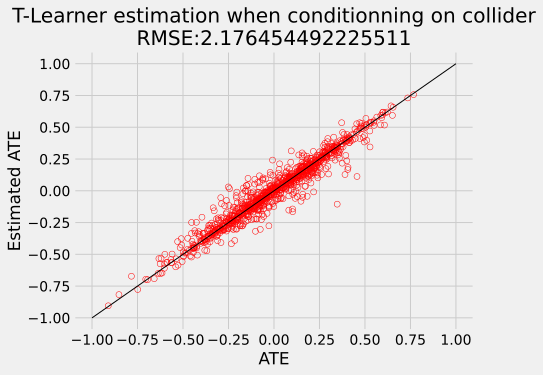

In [218]:
plt.scatter(ate, est_ate_total, facecolors='none', edgecolors='r')
plt.plot([-1,1],[-1,1], color="black", linewidth=1)
plt.title(f"T-Learner estimation when conditionning on collider\nRMSE:{np.linalg.norm(ate-est_ate_total, ord=2)}")

plt.xlabel("ATE")
plt.ylabel("Estimated ATE")
plt.show()

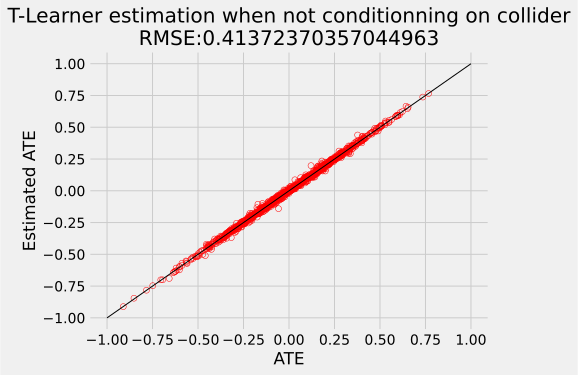

In [217]:
plt.scatter(ate, est_ate_partial, facecolors='none', edgecolors='r')
plt.plot([-1,1],[-1,1], color="black", linewidth=1)
plt.title(f"T-Learner estimation when not conditionning on collider\nRMSE:{np.linalg.norm(ate-est_ate_partial, ord=2)}")

plt.xlabel("ATE")
plt.ylabel("Estimated ATE")
plt.show()

In [52]:
_, c0, _ = csl.causalImpact(cslbn2, on="Y", doing="T", 
    values={"T":0, "X1":1, "X2":1, "X3":1, "V1":1, "V2":1, "V3":1}, 
    knowing={"X1", "X2", "X3", "V1", "V2", "V3"})
_, c1, _ = csl.causalImpact(cslbn2, on="Y", doing="T", 
    values={"T":1, "X1":1, "X2":1, "X3":1, "V1":1, "V2":1, "V3":1}, 
    knowing={"X1", "X2", "X3", "V1", "V2", "V3"})

diff = c1 - c0
ate = diff.expectedValue(lambda d : diff.variable(0).numerical(d[diff.variable(0).name()]))
ate

0.0

In [78]:

parameter_learner = gum.BNLearner(df, cslbn.causalBN())
parameter_learner.useNMLCorrection()
parameter_learner.useSmoothingPrior(1e-9)

bn = gum.BayesNet(cslbn.causalBN())
parameter_learner.fitParameters(bn)

cslbn = csl.CausalModel(bn)

To do:

Trouver un oyen de conditionner sur des prior continue pyAgrum. Sur les autres variables, ca se faisait avec requetes pandas. Mais avec pyAgrum puisque il y a discretisaation, pas possible. 

Utilse pour generation de CATE, ITE. 

Voir comment utiliser BNLearner avec variables latentes. 